### Data Set Information:

Predicting forest cover type from cartographic variables only. The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.


### Attribute Information:

Given is the attribute name, attribute type, the measurement unit and a brief description. The forest cover type is the classification problem. The order of this listing corresponds to the order of numerals along the rows of the database.

Name / Data Type / Measurement / Description

Elevation / quantitative /meters / Elevation in meters <br>
Aspect / quantitative / azimuth / Aspect in degrees azimuth <br>
Slope / quantitative / degrees / Slope in degrees <br>
Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features <br>
Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features <br>
Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway <br>
Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice <br>
Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice <br>
Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice <br>
Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points <br>
Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation<br>
Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation<br>
Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation


### Modeling: 
We start with importing the required Snowflake and Python packages into our notebook

In [40]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import col
from snowflake.snowpark.types import *
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from snowflake.snowpark.functions import udf
%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns
import snowflake.connector
from snowflake.connector import pandas_tools as sfpd

Load the source file. Column names are not in the source file, hence had to be created and assigned to the dataframe created when the file is loaded.

In [41]:
covertype= pd.read_csv('/Users/vbatra/Downloads/covtype.data.gz', header=0,compression='gzip', sep=',', quotechar='"')


In [42]:
covertype.shape

(581011, 55)

In [43]:
colnames=['ELEVATION',
'ASPECT',                                 
'SLOPE',                                   
'HORIZONTAL_DISTANCE_TO_HYDROLOGY',
'VERTICAL_DISTANCE_TO_HYDROLOGY',
'HORIZONTAL_DISTANCE_TO_ROADWAYS'  ,       
'HILLSHADE_9AM',
'HILLSHADE_NOON',             
'HILLSHADE_3PM',
'HORIZONTAL_DISTANCE_TO_FIRE_POINTS',     
'WA_1','WA_2','WA_3','WA_4',
'ST_2702','ST_2703', 'ST_2704','ST_2705','ST_2706','ST_2717','ST_3501','ST_3502','ST_4201','ST_4703','ST_4704',
'ST_4744','ST_4758','ST_5101','ST_5151','ST_6101','ST_6102','ST_6731','ST_7101', 'ST_7102','ST_7103', 'ST_7201',
'ST_7202', 'ST_7700','ST_7701', 'ST_7702',  'ST_7709','ST_7710','ST_7745',   'ST_7746', 'ST_7755',  'ST_7756',
'ST_7757','ST_7790'  ,'ST_8703','ST_8707','ST_8708','ST_8771','ST_8772','ST_8776','COVER_TYPE']
covertype.columns = colnames

Set connection parameters and create a new session

In [88]:
from snowflake.snowpark import Session
import json

with open('creds.json') as f:
    connection_parameters = json.load(f)    
session = Session.builder.configs(connection_parameters).create()

Defining dependent and independent variables and splitting the data into training and test set.

In [45]:
X = covertype.drop('COVER_TYPE',axis=1)
y = covertype['COVER_TYPE']
covertype_train = covertype.sample(frac = 0.8)
covertype_test = covertype.drop(covertype_train.index)

Loading our test data into a table in Snowflake using the Python connector

In [46]:
%%time
# First create the table
covertype_test["id"]=covertype_test.index
list_val = [i+ " number" for i in covertype_test.columns]
query = f""" create or replace table covertype_test ({','.join(map(str, list_val))})"""
session.sql(query).collect()
conn = snowflake.connector.connect(**CONNECTION_PARAMETERS)
cur = conn.cursor()
# cur.execute('use role accountadmin;')
covertype_test.columns = [i.upper() for i in covertype_test.columns]
#populate the table
success, nchunks, nrows, _ = sfpd.write_pandas(conn, covertype_test,"COVERTYPE_TEST")

CPU times: user 679 ms, sys: 44.5 ms, total: 723 ms
Wall time: 11.6 s


In [87]:
# or convert the pandas df to Snowflake df and write to the table

#snowdf = session.createDataFrame(covertype_test.values.tolist()).toDF(list(covertype_test.columns)) 
#snowdf.write.mode("overwrite").saveAsTable("covertype_test")

In [48]:
covertype_testdf = session.table("covertype_test")

Some simple exploration of the data

In [81]:
covertype_testdf.select("ELEVATION","ASPECT","COVER_TYPE")\
.filter(covertype_testdf["ELEVATION"]==2590)\
.show()

-----------------------------------------
|"ELEVATION"  |"ASPECT"  |"COVER_TYPE"  |
-----------------------------------------
|2590         |56        |5             |
|2590         |93        |6             |
|2590         |9         |2             |
|2590         |24        |2             |
|2590         |98        |2             |
|2590         |262       |2             |
|2590         |123       |2             |
|2590         |44        |2             |
|2590         |56        |2             |
|2590         |72        |2             |
-----------------------------------------



In [79]:
%%time
covertype_testdf.select("ELEVATION","ASPECT","COVER_TYPE")\
.groupBy("COVER_TYPE").count()\
.sort("COUNT", ascending=False)\
.show()

--------------------------
|"COVER_TYPE"  |"COUNT"  |
--------------------------
|2             |56670    |
|1             |42252    |
|3             |7231     |
|7             |4146     |
|6             |3457     |
|5             |1887     |
|4             |559      |
--------------------------

CPU times: user 13.4 ms, sys: 3.19 ms, total: 16.6 ms
Wall time: 442 ms


In [82]:
features = list(X.columns)
input_types=[]
for i in features:
    input_types.append(FloatType())

### DecisionTree Classifier:

In [8]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

Max_depth parameter detemines the depth of the tree the model builds. Higher value can lead to overfitting and an unexplainable model. If the parameter is not specified the model in this study went to a depth of 45. (Fitting and scoring time wasn not too different between depth 5 and depth 45. You can play around with the setting). Random_state parameter allows us the see repeatable model results.

In [83]:
dtree_clf = DecisionTreeClassifier(max_depth=3, random_state=3)\
.fit(covertype_train[features], covertype_train['COVER_TYPE'])

Creating the UDF and pushing the model data and algorithm to Snowflake

In [11]:
dtree_model = udf(
    
        lambda *args: 
                                    dtree_clf.predict(pd.DataFrame([args], columns=features))[0],
                                    return_type=IntegerType(),
                                    input_types= input_types)

Inferencing the forest covertype with test data. The predicted values are then converted to integer data type for later calculations. In this case all test data fits into a single micro-partition, so irrespective of the Warehouse size the scoring takes over 4 minutes. You can demonstrate paralleism by increasing the scoring data size (** insert into select * from sametable **). Scoring 25x more data takes the same amount of time if run on L or XL warehouses. 

In [12]:
output = covertype_testdf.select(*features,
                    dtree_model(*features).alias('PREDICTED_COVERTYPE'), 
                    (F.col('COVER_Type')).alias('ACTUAL_COVERTYPE')
                    ).toPandas()
output["PREDICTED_COVERTYPE"] = output["PREDICTED_COVERTYPE"].astype(int)

#### Model performance evaluation:
With max_depth = 5, the model is 74% accurate. At depth 40, it was 98% accurate. That could be because of overfitting. 

 The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

In [21]:
print(classification_report(output["PREDICTED_COVERTYPE"],output["ACTUAL_COVERTYPE"], zero_division=0))

              precision    recall  f1-score   support

           1       0.69      0.64      0.67     45168
           2       0.73      0.73      0.73     57020
           3       0.79      0.58      0.67      9753
           4       0.38      0.31      0.34       625
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.48      0.55      0.51      3636

    accuracy                           0.67    116202
   macro avg       0.44      0.40      0.42    116202
weighted avg       0.71      0.67      0.69    116202



In [22]:
pd.pivot_table(data=output, values='ELEVATION',index='ACTUAL_COVERTYPE',columns='PREDICTED_COVERTYPE',aggfunc='count')

PREDICTED_COVERTYPE,1,2,3,4,7
ACTUAL_COVERTYPE,,,,,
1,29106.0,11497.0,30.0,2.0,1517.0
2,13946.0,41390.0,1228.0,49.0,126.0
3,NaN,1311.0,5668.0,165.0,NaN
4,NaN,NaN,325.0,195.0,NaN
5,NaN,1775.0,147.0,2.0,NaN
6,NaN,1046.0,2337.0,212.0,NaN
7,2116.0,1.0,18.0,NaN,1993.0


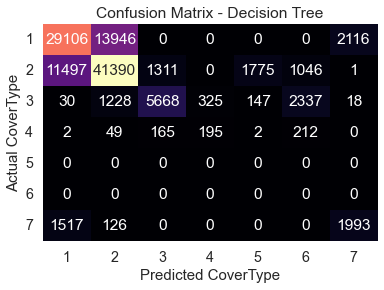

<Figure size 720x504 with 0 Axes>

In [23]:
# Heatmap of model accuracy
labels=[1,2,3,4,5,6,7]

confusion_matrix = metrics.confusion_matrix(output["PREDICTED_COVERTYPE"],output["ACTUAL_COVERTYPE"])#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma", cbar=False)#set axis titles
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted CoverType", fontsize =15)
#ax.set_xticklabels(['']+labels)
ax.set_xticklabels(list(labels), rotation = 0)
ax.set_ylabel("Actual CoverType", fontsize=15)
ax.set_yticklabels(list(labels), rotation = 0)
plt.show()

Understanding the most important variables affecting forest covertype. It looks like Elevation is by far the most dominant feature affecting the outcome. 

In [24]:
#extract importance
importance = pd.DataFrame({'feature': X.columns, 
'importance' : np.round(dtree_clf.feature_importances_, 3)})
importance.sort_values('importance', ascending=False, inplace = True)
print(importance.head(7))

                             feature  importance
0                          ELEVATION       0.910
17                           ST_2705       0.039
7                     HILLSHADE_NOON       0.030
12                              WA_3       0.014
3   HORIZONTAL_DISTANCE_TO_HYDROLOGY       0.007
41                           ST_7710       0.000
31                           ST_6731       0.000


In [17]:
# Decision Tree navigation path breakoff criteria.
from sklearn.tree import export_text
tree_rules = export_text(dtree_clf,
                        feature_names = features)
print(tree_rules)

|--- ELEVATION <= 3044.50
|   |--- ELEVATION <= 2510.50
|   |   |--- HORIZONTAL_DISTANCE_TO_HYDROLOGY <= 15.00
|   |   |   |--- class: 4
|   |   |--- HORIZONTAL_DISTANCE_TO_HYDROLOGY >  15.00
|   |   |   |--- class: 3
|   |--- ELEVATION >  2510.50
|   |   |--- ST_2705 <= 0.50
|   |   |   |--- class: 2
|   |   |--- ST_2705 >  0.50
|   |   |   |--- class: 3
|--- ELEVATION >  3044.50
|   |--- ELEVATION <= 3314.50
|   |   |--- HILLSHADE_NOON <= 240.50
|   |   |   |--- class: 1
|   |   |--- HILLSHADE_NOON >  240.50
|   |   |   |--- class: 1
|   |--- ELEVATION >  3314.50
|   |   |--- WA_3 <= 0.50
|   |   |   |--- class: 1
|   |   |--- WA_3 >  0.50
|   |   |   |--- class: 7



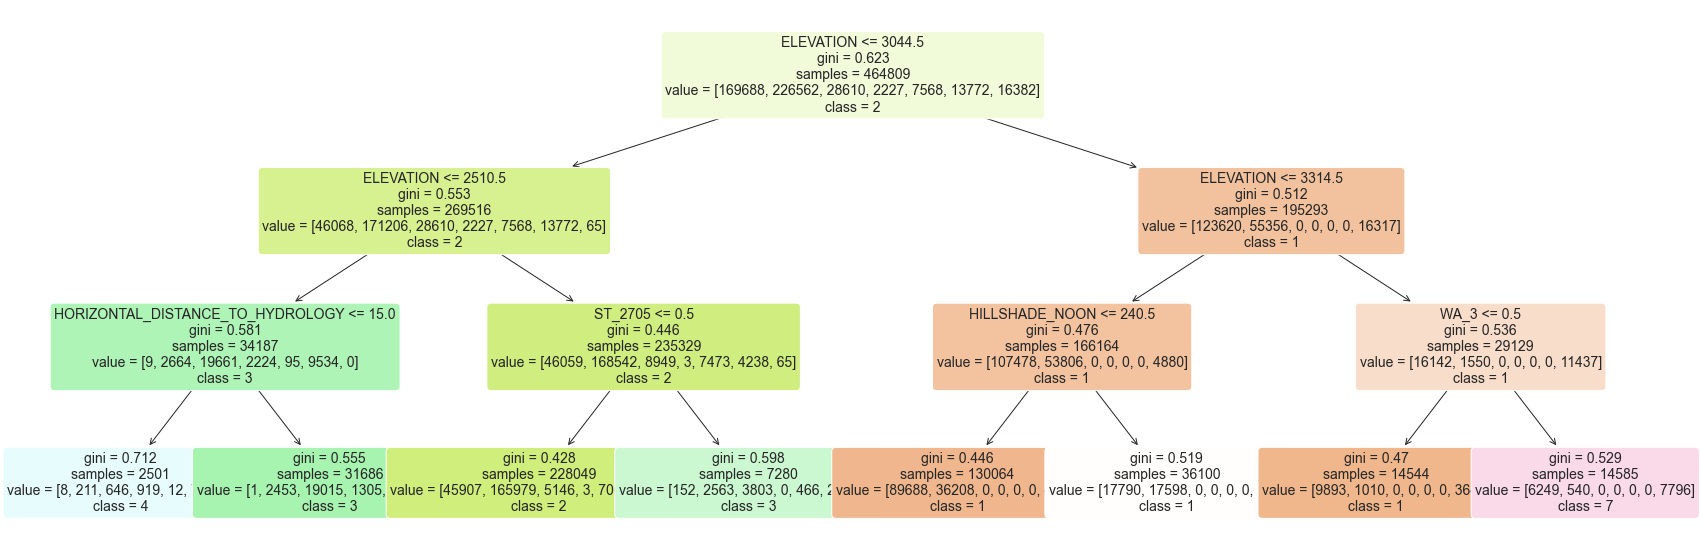

In [18]:
# Visual of the decision tree
from sklearn import tree

plt.figure(figsize=(30,10), facecolor ='white')#create the tree plot
a = tree.plot_tree(dtree_clf,
                   #use the feature names stored
                   feature_names = features,
                   #use the class names stored
                   class_names = ['1','2','3','4','5','6','7'],
                   rounded = True,
                   filled = True,
                   fontsize=14)
plt.show()

### RandomForest Classifier:
We can repeat the exact same process using RandomForest model. RF takes longer to score for the same amount of data (~ 7 mins vs 4 mins). Keep n_estimators under 10. Rightnow UDF creation process fails for larger values --Bug identified.

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=5, n_jobs=-1)
rfc.fit(covertype_train[features], covertype_train['COVER_TYPE'])

RandomForestClassifier(n_estimators=5, n_jobs=-1)

In [25]:
rfc_model = udf(
    
        lambda *args: 
                                    rfc.predict(pd.DataFrame([args], columns=features))[0],
                                    return_type=IntegerType(),
                                    input_types= input_types)

In [ ]:
output = covertype_testdf.select(*features,
                    rfc_model(*features).alias('PREDICTED_COVERTYPE'), 
                    (F.col('COVER_Type')).alias('ACTUAL_COVERTYPE')
                    ).toPandas()

In [ ]:
output["PREDICTED_COVERTYPE"] = output["PREDICTED_COVERTYPE"].astype(int)

In [ ]:
print(classification_report(output["PREDICTED_COVERTYPE"],output["ACTUAL_COVERTYPE"]))

In [ ]:
pd.pivot_table(data=output, values='ELEVATION',index='ACTUAL_COVERTYPE',columns='PREDICTED_COVERTYPE',aggfunc='count')

### Batching prediction
This approach is used to speed up scoring/inference by batching inputs to the predictive model. Below two functions batch and unbatch the output.

create or replace function batch(id double, input array)
    returns table (batched_ids array, batched_inputs array)
    language javascript
    as '{
    processRow: function (row, rowWriter, context) {
      this.ids.push(row.ID);
      this.inputs.push(row.INPUT);
      if (this.inputs.length >= 1000) {
        rowWriter.writeRow({BATCHED_IDS: this.ids, BATCHED_INPUTS: this.inputs});
        this.ids = [];
        this.inputs = [];
      }
    },
    finalize: function (rowWriter, context) {
     if (this.inputs.length > 0) {
        rowWriter.writeRow({BATCHED_IDS: this.ids, BATCHED_INPUTS: this.inputs});
     }
    },
    initialize: function(argumentInfo, context) {
     this.ids = [];
     this.inputs = [];
    }}';


create or replace function unbatch(batched_ids array, batched_inputs array)
    returns table (id double, output float)
    language javascript
    as '{
    processRow: function (row, rowWriter, context) {
      for (var i = 0; i < row.BATCHED_IDS.length; i++) {
        var id = row.BATCHED_IDS[i];
        var r = row.BATCHED_INPUTS[i];
        rowWriter.writeRow({ID: id, OUTPUT: r});
      }
    }}';

In [84]:
dtree_clf5 = DecisionTreeClassifier(max_depth=5, random_state=3).fit(covertype_train[features], covertype_train['COVER_TYPE'])

In [27]:
dtree_model = udf(
    lambda rows: 
        dtree_clf5.predict(pd.DataFrame(rows, columns=features)).tolist(),
        return_type=ArrayType(FloatType()),
        input_types=[ArrayType(FloatType())],
        name="predict_udf5",
        is_permanent=True,
        stage_location="@pystage")


In [85]:
%%time
output5 = session.sql(
 "select covertype_test.*, output as PREDICTED_COVERTYPE from \
    (select batched_ids, batched_inputs, predict_udf5(batched_inputs) AS PREDICTED_COVERTYPE_BATCH\
    from covertype_test, table(batch(id::double, ARRAY_CONSTRUCT(ELEVATION,ASPECT,SLOPE,\
      HORIZONTAL_DISTANCE_TO_HYDROLOGY,VERTICAL_DISTANCE_TO_HYDROLOGY,\
      HORIZONTAL_DISTANCE_TO_ROADWAYS,HILLSHADE_9AM,HILLSHADE_NOON,HILLSHADE_3PM,HORIZONTAL_DISTANCE_TO_FIRE_POINTS,\
      WA_1,WA_2,WA_3,WA_4,ST_2702,ST_2703,ST_2704,ST_2705,ST_2706,ST_2717,ST_3501,ST_3502,ST_4201,ST_4703,ST_4704,\
      ST_4744,ST_4758,ST_5101,ST_5151,ST_6101,ST_6102,ST_6731,ST_7101,ST_7102,ST_7103,ST_7201,ST_7202,ST_7700,\
      ST_7701,ST_7702,ST_7709,ST_7710,ST_7745,ST_7746,ST_7755,ST_7756,ST_7757,ST_7790,ST_8703,ST_8707, ST_8708,\
      ST_8771,ST_8772,ST_8776)))),table(unbatch(batched_ids, PREDICTED_COVERTYPE_BATCH)) as unbatched \
join covertype_test on covertype_test.id = unbatched.id"
).toPandas()

CPU times: user 900 ms, sys: 74.6 ms, total: 974 ms
Wall time: 11.7 s


In [86]:
output5.head()

,ELEVATION,ASPECT,SLOPE,HORIZONTAL_DISTANCE_TO_HYDROLOGY,VERTICAL_DISTANCE_TO_HYDROLOGY,HORIZONTAL_DISTANCE_TO_ROADWAYS,HILLSHADE_9AM,HILLSHADE_NOON,HILLSHADE_3PM,HORIZONTAL_DISTANCE_TO_FIRE_POINTS,...,ST_7790,ST_8703,ST_8707,ST_8708,ST_8771,ST_8772,ST_8776,COVER_TYPE,ID,PREDICTED_COVERTYPE
0,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,5,0,2.0
1,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,2,1,2.0
2,2612,59,10,247,11,636,228,219,124,6230,...,0,0,0,0,0,0,0,5,8,2.0
3,2503,38,5,85,10,741,220,228,144,5555,...,0,0,0,0,0,0,0,5,18,3.0
4,2880,209,17,216,30,4986,206,253,179,4323,...,0,0,0,0,0,0,0,2,20,2.0


In [39]:
print(classification_report(output5["PREDICTED_COVERTYPE"],output["COVER_TYPE"]))

              precision    recall  f1-score   support

         1.0       0.68      0.68      0.68     42243
         2.0       0.78      0.73      0.75     60863
         3.0       0.85      0.62      0.72      9790
         4.0       0.33      0.56      0.42       308
         5.0       0.05      0.48      0.09       194
         6.0       0.04      0.72      0.07       197
         7.0       0.45      0.71      0.55      2607

    accuracy                           0.70    116202
   macro avg       0.45      0.64      0.47    116202
weighted avg       0.74      0.70      0.71    116202



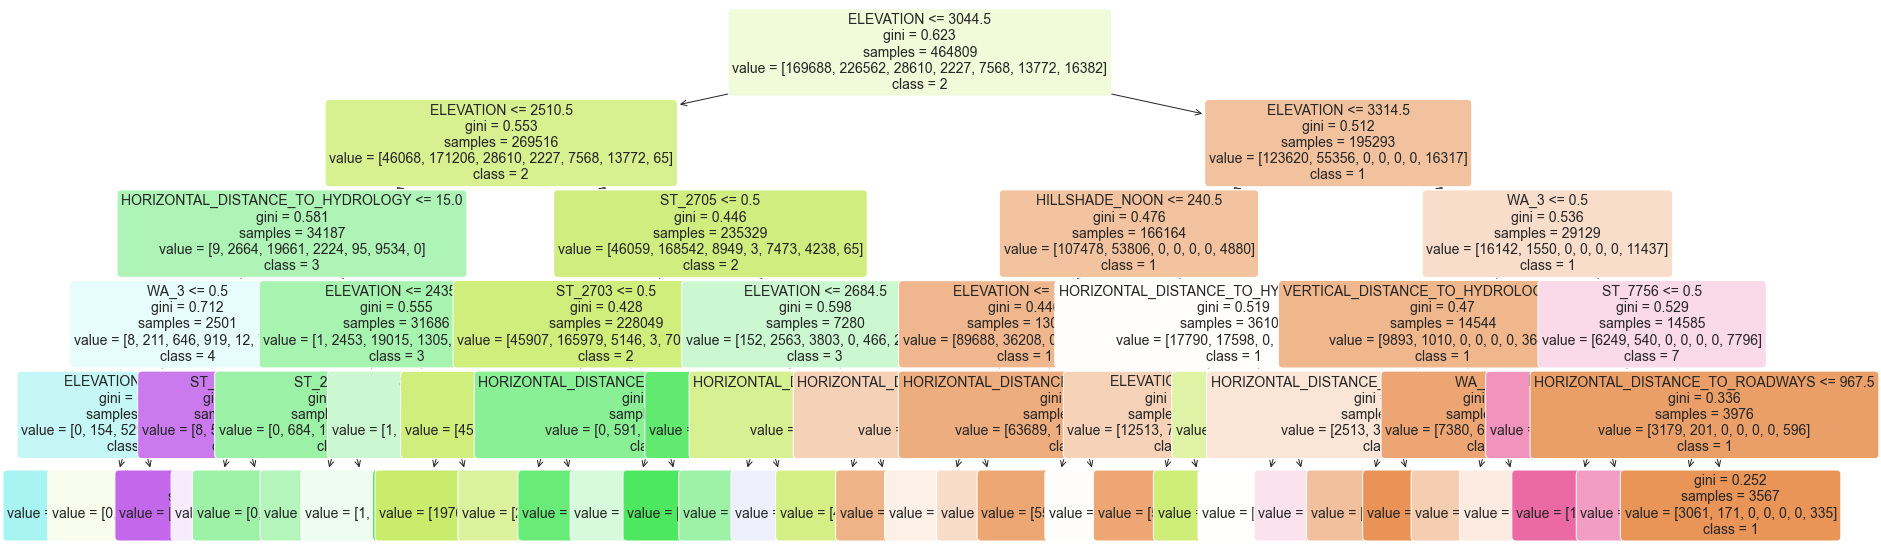

In [36]:
# Visual of the decision tree
from sklearn import tree

plt.figure(figsize=(30,10), facecolor ='white')#create the tree plot
a = tree.plot_tree(dtree_clf5,
                   #use the feature names stored
                   feature_names = features,
                   #use the class names stored
                   class_names = ['1','2','3','4','5','6','7'],
                   rounded = True,
                   filled = True,
                   fontsize=14)
plt.show()

In [ ]:
session.close()